\title{Analog Mosfet Topology Repository for use with Python}
\author{Steven K Armour}
\maketitle

Note:
this notebook uses the [`(some) LaTeX environments for Jupyter
`](http://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/latex_envs/README.html) found within the install of https://github.com/ipython-contrib/jupyter_contrib_nbextensions

All diagrams are made in **draw.io** where the source file is `MOSFETTobos.html` where that file and the exported files should accompany this notebook from its GitHub source

!!! Also, note at this point with PySpice 1.2 complex numbers are not being returned from NgSpice AC sim; when this is fixed this notebook will be updated

# Premise
This Notebook serves as a Repository of Analog MOSFET Topologies for use in [PySpice](https://pyspice.fabrice-salvaire.fr/) and for the topologies theory. The Goal for the Author personally is to make one or two upgrades to this notebook a week. Whether that be a new feature, expanded theory, or new topology.

Some of the intended upgrades include:
\begin{itemize}
\item Enhanced analyses of output data
\item Routines to find figures of merits from output data
\item Added calculations from theory 
\item Simulations from theory and compersion to SPICE sim
\item adding GUI interactivity via ipython notebook widgets
\end{itemize}



# Libarys

In [1]:
from sympy import *
init_printing()
import ipywidgets as wgs

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import fftpack as SciFFT
import peakutils



from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Unit import *

#hide warning from pandas
import warnings
warnings.filterwarnings('ignore')

#https://github.com/jrjohansson/version_information
%load_ext version_information
%version_information sympy, numpy, matplotlib, pandas, PySPice, scipy, peakutils 

Software,Version
Python,3.6.3 64bit [GCC 7.2.0]
IPython,6.2.1
OS,Linux 4.13.0 38 generic x86_64 with debian stretch sid
sympy,1.1.2.dev
numpy,1.13.3
matplotlib,2.1.0
pandas,0.21.0
PySPice,1.2.0
scipy,0.19.1
peakutils,1.1.1


The following cell will import all the spice model files in the subdirectory `SpiceLib`. Further, since these topologies are for non-discrete libraries (meaning you set the W/L) only technologies libraries will be used. The default technology is the 180nm technology from TSMC found http://www.ece.umd.edu/~newcomb/courses/spring2010/303/tsmc180nmcmos.lib but has been separated into its NMOS and PMOS with modifications to mak it compatible with BSIM 3.3/ NgSPICE/ PySpice

In [2]:
libraries_path = 'SpiceLib/'
spice_library = SpiceLibrary(libraries_path)
Tech='TSMC180nmN'

# Rail Voltage Supplies

## Postive Rail Vss

<img src="Vss.png">

## Negtive Rail Vdd

<img src="Vdd.png">

# Two Port  Network Test Bench

In [3]:
class TwoPortTB(Circuit):
    """
    Test Bench with semi automated 
    DC Transfer; NA Scatering; and Harmonic Anylsis
    """
    def __init__(self, DUT, DUTName, NMOS_Tech,**kwargs):
        """
        Intialize the this ciruit instaince; test cirucit is intiated
        in `self.SetupCir`
        
        Args:
            DUT (class): the elgibale 2P subcir (class) that is to be 
            investegated
            
            DUTName (str): name of the elgible 2P subcir that is to be 
            investegated
            
            NMOS_Tech (str): the MOSFET technology to be used in the
            investagation that is found in sourced spice libary
            
            **kargs (None): not used; is a remenent from the inhartince
            of `Circuit`
        """
        #store the DUT; DUTName; Tech in class instance
        self.DUTName=DUTName
        self.DUT=DUT; self.NMOS_Tech=NMOS_Tech
        super().__init__(title=f'{DUTName}_TB', **kwargs)
        self.include(spice_library[self.NMOS_Tech])
    
    def SetupCir(self, Vprail=1.8, Vnrail=0, **kwargs):
        """
        Method that acutrly sets up the Test Bench with the DUT 
        Args:
            Vprail (float; 1.8; V): the Top Rail source ex Vss, voltage 
            Vnrail (float; 0; V): the Bottom Rail source ex Vdd, voltage 
            **kwargs (dict): addital arguments in a dict of argument values 
            pairs where the arguments are strings to be passed as arguments
            to the DUT during its setup
            
        """
        #store the rail voltags used in DCTransfer Anylsis and elsewhere
        self.Vprail=Vprail; self.Vnrail=Vnrail
        #create the rail supply sources
        #Note: will most likly be moved to subcirucits in the near futute
        self.VoltageSource('ss', 'Vp', self.gnd, Vprail@u_V)
        self.VoltageSource('dd', self.gnd, 'Vn', Vnrail@u_V)
        
        #instatinte the DUT with the arguments from kwargs
        self.DUT=self.DUT(self.NMOS_Tech, **kwargs)
        # bind the 2P (One In, One out, Ref to ground) 2Rial DUT 
        #to the subcirucit
        self.subcircuit(self.DUT)
        self.X(f'{self.DUTName}', self.DUT.__name__, 'Vp','Vn', 
               'Vin', 'Vout')
        
        #setup simulator with room temp conditions
        self.sim=self.simulator(temperature=24, nominal_temperature=24)

    
    def VIPTransferCurvesGen(self, Steps=50):
        """
        Method to modify the testbench to perform a DC sweep to ascertain the 
        DC transfer curves (Vout, Id, Power) vs Vin
        
        The method then proceeds to call `self._VIPAnylsis` that analysis
        the Voltage Transfer Curve(VTC) (Vin vs Vout) for critical points defined
        in Chapter 1.3, 1.4, 1.5 of ISBN-10: 0471108057
        
        Then calls `self._TCPlots` to generate the resulting plots showing
        the transfer curves; critical points and figure of merit information
        
        
        Args:
            Steps (int; 50): the number of step increments to take during 
            the DC sweep
        
        Returns:
            self.VIPResults (PySpice Results): the output information of the
            DC sweep simulation where the data is pulled from
            
            self.VIPData (pandas Dataframe): Dataframe with the information from `self.VIPResults` is stored in a table manner
            
            self.VTCCriticalPoints (dict): from `self._VIPAnylsis` method; 
            dictory storing VTC criticl points informtion
            
            self.VTCMeassures (dict): from `self._VIPAnylsis` method; 
            dictory storing VTC measures
            
            plot outputs from `self._TCPlots` method
            
        """
        # add voltage sour to Vin; try:except is there if this method
        #has already been called and elements are already in ciruit
        try:
            self.VIPSource=self.VoltageSource('VIP_TS', 'Vin', self.gnd, self.Vnrail)
            print(self)
        except NameError:
            pass
        
        #calc step size from from number of steps using rail voltages 
        # as lower and upper bounds for the sweep range
        StepSize=(self.Vprail-self.Vnrail)/Steps
        #perform the DC sweep simulation and bind result to self
        self.VIPResults=self.sim.dc(VVIP_TS=slice(self.Vnrail, self.Vprail, StepSize))
        
        #create dataframe of DC sweep information and bind the necery data to it
        self.VIPData=pd.DataFrame()
        self.VIPData['Vin[V]']=pd.Series(np.array(self.VIPResults.sweep))
        self.VIPData['Vout[V]']=pd.Series(np.array(self.VIPResults.Vout))
        self.VIPData['I[A]']=pd.Series(-np.array(self.VIPResults.vdd))
        self.VIPData['P[W]']=self.VIPData['I[A]']*self.VIPData['Vout[V]']
        
        #remove the added elements to perform this anyleis
        self.VIPSource.detach()
        
        #call the other methods in this anyleis sequance
        self._VIPAnylsis()
        self._TCPlots()
    
    def _VIPAnylsis(self):
        """
        Method that that analysis the Voltage Transfer Curve(VTC) (Vin vs Vout) 
        for critical points defined in Chapter 1.3, 1.4, 1.5 of 
        ISBN-10: 0471108057
        
        Method is normal called from within `self.VIPTransferCurvesGen`
        
        Args:
            None
        Returns:
            self.VTCCriticalPoints (dict): from `self._VIPAnylsis` method; 
            dictory storing VTC criticl points informtion
            
            self.VTCMeassures (dict): from `self._VIPAnylsis` method; 
            dictory storing VTC measures
            
            additinal columns to `self.VIPData`
            
        """
        
        #Dervitives of VTC
        self.VIPData['Grad']=np.gradient(self.VIPData['Vout[V]'], self.VIPData['Vin[V]'])
        self.VIPData['GradMag']=np.abs(self.VIPData['Grad'])
        self.VIPData['GGrad']=np.gradient(self.VIPData['Grad'], self.VIPData['Vin[V]'])
        
        #Crtical Point Anylsisi
        VILLoc=np.abs(self.VIPData['GGrad']--1.0).idxmax()
        VIHLoc=np.abs(self.VIPData['GGrad']--1.0).idxmin()
        VIHLoc=np.abs(self.VIPData['GGrad']--1.0).idxmin()
        VIMLoc=np.abs(self.VIPData['Grad']-0).idxmax()
        #VILLoc, VIHLoc, VIMLoc
        VILV=self.VIPData['Vin[V]'][VILLoc]; VOLV=self.VIPData['Vout[V]'][VILLoc]
        VIHV=self.VIPData['Vin[V]'][VIHLoc]; VOHV=self.VIPData['Vout[V]'][VIHLoc]
        VIMV=self.VIPData['Vin[V]'][VIMLoc]; VOMV=self.VIPData['Vout[V]'][VIMLoc]
        
        self.VTCCriticalPoints={
            'VInLow':VILV, 'VOutLow': VOLV,
            'VInHigh':VIHV, 'VOutHigh':VOHV,
            'VInMid': VIMV, 'VOutMid': VOMV
        }
        
        #VTC Fig of Merit
        self.VTCMeassures={'LogicSwing':VOHV-VOLV,
            'TranssitionWidth':VIHV-VILV,
             'NoiseMarHigh':VOHV-VIHV,
             'NoiseMarLow':VILV-VOLV,
             'NoiseSenHigh': VOHV-VIMV,
             'NoiseSenLow': VIMV-VOLV          
            }
        self.VTCMeassures['NoiseImmuntyHigh']=self.VTCMeassures['NoiseSenHigh']/self.VTCMeassures['LogicSwing']
        self.VTCMeassures['NoiseImmuntyLow']=self.VTCMeassures['NoiseSenHigh']/self.VTCMeassures['LogicSwing']
        self.VTCMeassures
        
        # find the max dc Voltage Gain and the 2nd dervitve at that loc
        PeakDCOut=self.VIPData['GradMag'].max()
        PeakDCIn=self.VIPData['Vin[V]'][np.abs(self.VIPData['GradMag']--PeakDCOut).idxmax()]
        N2Harmonic=self.VIPData['GGrad'][np.abs(self.VIPData['GradMag']--PeakDCOut).idxmax()]
        self.VTCCriticalPoints['AvDCInMax']=PeakDCIn
        self.VTCCriticalPoints['AvDCOutMax']=PeakDCOut
        self.VTCMeassures['AvDCMax']=PeakDCOut/PeakDCIn
        self.VTCMeassures['2ndDer@AvDCMax']=N2Harmonic
    
    def _TCPlots(self):
        
        """
        Method that plots the DcTransfer curve information and displayes 
        the VTC figures of merite
        
        Method is normal called from within `self.VIPTransferCurvesGen`
        Args:
            None
        Returns:
            None

        """
        
        #create the fig and subplot panals
        fig, [Pow, Irail, vtc, vtcGrad, vtcGradM,  vtcGGrad]=plt.subplots(nrows=6, ncols=1, sharex=True)
        fig.set_size_inches(8, 8)
        
        Pow.set_title('DC Transfer Curves')
        
        #plot power curve
        self.VIPData.plot(x='Vin[V]', y='P[W]', ax=Pow)
        Pow.set_ylabel('P[W]')
        
        #plot current curve
        self.VIPData.plot(x='Vin[V]', y='I[A]', ax=Irail)
        Irail.set_ylabel('I[A] rail-rail')
        
        #plot VTC curve
        self.VIPData.plot(x='Vin[V]', y='Vout[V]', ax=vtc)
        vtc.set_ylim(0, self.VIPData['Vout[V]'].max()*1.2)
        vtc.set_ylabel('v_o')
        
        #plot the 
        self.VIPData.plot(x='Vin[V]', y='Grad', ax=vtcGrad)
        vtcGrad.set_ylabel(r'$\partial v_o$')
        
        #plot the Avdc curve
        self.VIPData.plot(x='Vin[V]', y='GradMag', ax=vtcGradM)
        vtcGradM.set_ylabel(r'$|\partial v_o|$')
        
        #plot the 2nd Derv of the VTC curve
        self.VIPData.plot(x='Vin[V]', y='GGrad', ax=vtcGGrad);
        vtcGGrad.set_ylabel(r'$\partial^2 v_o$')

        #add lines for the where the critical points are
        for i in [Pow, Irail, vtc, vtcGrad, vtcGradM,  vtcGGrad]:
            i.axvline(x=self.VTCCriticalPoints['VInLow'], linestyle='--', alpha=0.7, color='k')
            if i==vtc:
                i.axhline(y=self.VTCCriticalPoints['VOutLow'], linestyle=':', alpha=0.4, color='k')

            i.axvline(x=self.VTCCriticalPoints['VInHigh'], linestyle='--', alpha=0.7, color='r')
            if i==vtc:
                i.axhline(y=self.VTCCriticalPoints['VOutHigh'], linestyle=':', alpha=0.4, color='r')

            i.axvline(x=self.VTCCriticalPoints['VInMid'], linestyle='--', alpha=0.7, color='g')
            if i==vtc:
                i.axhline(y=self.VTCCriticalPoints['VOutMid'], linestyle=':', alpha=0.4, color='g')

        #add to the right plots printouts on the plot fig
        # of the figure of mertites from the VTC curve
        Anotations1=['VTC Critical Points:\n']
        for K, V in self.VTCCriticalPoints.items():
            Anotations1.append('   '+f'{K}:{V:.3f}[V]' +'\n')
        Anotations1=''.join(Anotations1)
        fig.text(0.95,.4, Anotations1, fontsize=14, transform=fig.transFigure)

        Anotations2=['VTC Fig of Merits:\n']
        for K, V in self.VTCMeassures.items():
            Anotations2.append('   '+f'{K}:{V:.3f}' +'\n')
        Anotations2=''.join(Anotations2)
        fig.text(1.35,.4, Anotations2, fontsize=14, transform=fig.transFigure)
        
    
        plt.show()
        
    def NASetup(self, detach=False, Bias='Auto', Amp='Auto', Z0=50):
        """
        Method is implment a network anylizer on the testbench
        via conecting a voltage source with a series impedance to both
        the input and output of the DUT.
        
        !!! if using Auto for the sources setup `self.VIPTransferCurvesGen`
        must be run first
        
        Args:
            detach (bool; False): contorl to detach the NA elements from
            the testbench cirucit
            
            Bias (str/float; 'Auto'; [V]): DC bias voltage to the input and ouput
            NA ports; Auto will have this method find the dc Bias for the I/O
            ports from the Vin; Vout as the Vm point of the VTC
            
            Amp (str/float; 'Auto'; [V]): the Sinusiudal voltage amplitude used on
            the NA sources. if `Auto` the ampldutds will be 10% of the logic
            width and transsition widths found from the VTC
            
            Z0 (float, 50; [Ohms]): the chartiristic impedance of the NA
             
        """
        
        #store the char impedance
        self.Z0=Z0
        # calculate the the Bias and Amp from the VTC anyliss if Auto is used
        #try-except is used to make sure VTC curve is found
        try:
            if Bias=='Auto' and Amp=='Auto':
                # auto collect the bias and amp based on the following
                #for  a 2Port Active Network:
                #BiasIn = SX1 Bias from VInMid
                #AmpIn from 10% of TranssitionWidth
                #BiasOut = SX2 Bias from VOutMid
                #AmpIn from 10% of Logic Swing
                try:
                    #Biasis
                    BiasIn=self.VTCCriticalPoints['VInMid']
                    BiasOut=self.VTCCriticalPoints['VOutMid']
                    #Amps
                    AmpIn=np.abs(self.VTCMeassures['TranssitionWidth']@u_V)*.1
                    AmpOut=np.abs(self.VTCMeassures['LogicSwing']@u_V)*.1
                    #store the Biases and Amps
                    self.BiasIn=BiasIn; self.BiasOut=BiasOut
                    self.AmpIn=AmpIn; self.AmpOut=AmpOut
                except AttributeError:
                    #TODO should just make this recursive
                    BiasIn=self.VTCCriticalPoints['VInMid']
                    BiasOut=self.VTCCriticalPoints['VOutMid']
                    AmpIn=np.abs(self.VTCMeassures['TranssitionWidth']@u_V)*.1
                    AmpOut=np.abs(self.VTCMeassures['LogicSwing']@u_V)*.1
                    self.BiasIn=BiasIn; self.BiasOut=BiasOut
                    self.AmpIn=AmpIn; self.AmpOut=AmpOut
            
            #add the P1 (normal input) port source and impedance
            self.VS1=self.SinusoidalVoltageSource('S1', '1', self.gnd, 
                                       dc_offset=self.BiasIn@u_V, 
                                       amplitude=self.AmpIn)
            self.VSR1=self.R('SR1', '1', 'Vin', Z0@u_Ω)
            
            #add the P2 (normal ouput) port source and impedance
            self.VSR2=self.R('SR2','Vout', '2', Z0@u_Ω)
            self.VS2=self.SinusoidalVoltageSource('S2', '2', self.gnd, 
                                       dc_offset=self.BiasOut@u_V, 
                                       amplitude=self.AmpOut)
        except NameError:
            pass
        
        #detach protocal
        if detach:
            self.VS1.detach()
            self.VSR1.detach()
            self.VS2.detach()
            self.VSR2.detach()
            return None

        #print out the now modfied testbench and amp; bais info
        print(self)
        print(f"""
        SX1 Source is Biased at {float(self.BiasIn):.3e}[V]
        with Amplitude at {float(self.AmpIn):.3e}[V] ;
        SX2 Source is Biased at {float(self.BiasOut):.3E}[V]
        with Amplitude at {float(self.AmpOut):.3E}[V]
        """)
        
    def NARun(self, StartHz=1, StopHz=10e6):
        """
        Method to performe a simulated 2Port network anylsis via the
        fowared reflected wave method
        $$a= \dfrac{V+Z_o I}{2\sqrt{\Re{Z_0}}}$$
        $$b= \dfrac{V-Z_o^* I}{2\sqrt{\Re{Z_0}}}$$
        $$S=\dfrac{b}{a}$$
        based on the Testbench modfied setup created in `self.NASetup`
        that returns the Scatering parmters for the 2Port network
        
        This method then performs `self._IntialSplotA` to perform the initial analysis of the 
        S data (this will be changed as SciKit-RF is brought online) that plots and analysis the data. And then detaches the added circuity 
        to the testbench to that was add to do the NA sweep
        
        Args:
            StartHz (float; 1; Hz): starting freq sweep
            StopHz (float; 10e6; Hz): Stop freq sweep
        
        Returns:
            self.ResultsSX1: ac sweep data for SX1 information
            self.ResultsSX2: ac sweep data for SX2 information
            self.SMeasure: Dataframe with the S parmter informtion in its collums
            self.SMeasuredB (from self._IntialSplotA): dataframe with S parmters info 
            in dB 
            self.dB3FreqsAprox (self._IntialSplotA): dictanry of 3dB corner freqyanycs 
            for each of the S parmters
            plots of S data (self._IntialSplotA): plots of the dB mags of the S pamters
        """
        #calculation functions 
        #forward wave
        self.a=lambda V, I, Z0: (V+np.array(Z0)*I)/(2*np.sqrt(np.real(Z0)))
        #reflected wave
        self.b=lambda V, I, Z0: (V-np.array(Z0).conj()*I)/(2*np.sqrt(np.real(Z0)))
        # S_ij
        self.S=lambda b, a: b/a
        
        #storage
        self.SMeasure=pd.DataFrame(columns=['freq', 'S11', 'S21', 'S12', 'S22'])
        
        #SX1 Measurment
        #set sources
        #a1=Active, a2=0, 
        self.VS1.amplitude=self.AmpIn@u_V; self.VS1.dc_offset=self.BiasIn@u_V
        #testing with bias on S2 source elual to vout at mid
        self.VS2.amplitude=0@u_V; self.VS2.dc_offset=self.BiasOut@u_V
        # ac sweep
        self.ResultsSX1=self.sim.ac(
            start_frequency=StartHz@u_Hz, stop_frequency=StopHz@u_Hz, 
                    number_of_points=25,  variation='dec')
        #get the Vs and Is
        V1=np.array(self.ResultsSX1.Vin); #print(V1)
        V2=np.array(self.ResultsSX1.Vout);# print(V2)
        I1=np.array(-self.ResultsSX1.VS1); #print(I1)
        I2=np.array(-self.ResultsSX1.VS2); #print(I2)
        #find the incdent and refelected waves
        a1=self.a(V1, I1, self.Z0); 
        b1=self.b(V1, I1, self.Z0)
        b2=self.b(V2, I2, self.Z0)
        
        #recored SX1 measurments
        self.SMeasure['freq']=self.ResultsSX1.frequency
        self.SMeasure['S11']=self.S(b1, a1)
        self.SMeasure['S21']=self.S(b2, a1)
        
        #meassures SX2
        
        #a2=Active, a1=0, 
        self.VS1.amplitude=0@u_V; self.VS1.dc_offset=self.BiasIn@u_V
        self.VS2.amplitude=self.AmpOut@u_V; self.VS2.dc_offset=self.BiasOut@u_V
        #ac sweep
        self.ResultsSX2 = self.sim.ac(start_frequency=StartHz@u_Hz, stop_frequency=StopHz@u_Hz, number_of_points=25,  variation='dec')
        
        #get the Vs and Is
        V1=np.array(self.ResultsSX1.Vin); #print(V1)
        V2=np.array(self.ResultsSX1.Vout);# print(V2)
        I1=np.array(-self.ResultsSX1.VS1); #print(I1)
        I2=np.array(-self.ResultsSX1.VS2); #print(I2)
        
        #find the incdent and refelected waves
        a2=self.a(V2, I2, self.Z0); 
        b1=self.b(V1, I1, self.Z0)
        b2=self.b(V2, I2, self.Z0)
        
        #recored measurments
        self.SMeasure['S12']=self.S(b1, a2)
        self.SMeasure['S22']=self.S(b2, a2)
        
        #call the anylsisis and plot
        self._IntialSplotA()
        
        #remove the NA test structure from the Testbench
        self.NASetup(detach=True)
        
    def _IntialSplotA(self):
        """
        Method to perform anylsis and ploting of the S parmters
        from `self.NARun` where it is normaly called from
        
        Args:
            None
        Returns:
            self.SMeasuredB (from self._IntialSplotA): dataframe with S parmters info 
            in dB 
            self.dB3FreqsAprox (self._IntialSplotA): dictanry of 3dB corner freqyanycs 
            for each of the S parmters
            plots of S data (self._IntialSplotA): plots of the dB mags of the S pamters
        
        Note:
            method will be rewritten when Scikit-RF is brought in
        """
        #create auxlary data stores
        self.SMeasuredB=pd.DataFrame()
        self.SMeasuredB['freq']=self.SMeasure['freq']
        F=self.SMeasuredB['freq']
        self.dB3FreqsAprox={'S11':0, 'S12':0,
                            'S21':0, 'S22':0}
        #load the aux data stores
        for i in ['S11', 'S21', 'S12', 'S22']:
            #calc the dB info
            self.SMeasuredB[i]=10*np.log10(np.abs(self.SMeasure[i]))
            
            #find the 3dB point
            A=self.SMeasuredB[i]
            L=np.abs(np.abs(A-A.max())-3.0).idxmin()
            self.dB3FreqsAprox[i]=F[L]

        #plot S
        fig, axS=plt.subplots(ncols=1, nrows=1, sharex=True)
        
        self.SMeasuredB.plot(x='freq', y=['S11', 'S21', 'S12', 'S22'], 
                       logx=True, ax=axS)
        
        #write the the 3dB points to the right of the plot
        Anotations1=['3dB Points:\n']
        for K, V in self.dB3FreqsAprox.items():
            Anotations1.append('   '+f'{K} 3db: {V:.3e}[Hz]' +'\n')
            colors={'S11':'blue', 'S12':'green', 'S21':'orange', 'S22':'red'}
            axS.axvline(x=V, label=f'{K} 3dB[Hz]', linestyle=':', 
                        alpha=0.7, color=colors[K])

        Anotations1=''.join(Anotations1)
        
        axS.legend(loc='best')
        fig.text(0.95,.4, Anotations1, fontsize=14, transform=fig.transFigure)

    def HarmonicAnylsis(self, autoSetup=True, **kwargs):
        """
        Method to perform the basic harmonic (spectrum) analysis of the DUT
        using an applied sine wave source directly (no impedance matching) 
        to the Dut Vin and viewing the output voltage from a dummy load at
        Vout. The first 10 Ouputharmoics are found and the Total Harmonic Distortion 
        is found and reported
        
        !Note the auto setup is based on results from the NA analysis done by
        `self.NARun`
        
        Args:
            auto setup (bool; True): set the input bias and amplitude to that
            of the auto setup for the NA testing and the frequency to 
            half of the 3dB frequency of the S21 measurement
        Returns:
            self.ResultsHarm: the data from the transition analysis
            self.HarmonicsTime (dataframe): results of the transient analysis in time
            self.HarmonicsFreq (dataframe): results of the transient analysis in freq
            self.Harmonics (dataframe): a record of the harmonics of the input and out
            self.THD (float): the Total Harmonic Distortion in dB
            plot of the input and output spectrums with Harmonics
        """
        #setup
        #find the autoset values from amp; bias; S21 3dB freq/2; char Z0
        if autoSetup:
            f=self.dB3FreqsAprox['S21']/2
            b=self.BiasIn
            a=self.AmpIn
            Z=self.Z0
        else:
            f=kwargs['freq']
            b=kwargs['Bias']
            a=kwargs['Amp']
            Z=kwargs['Z0']
            
        try:
            self.HS=self.SinusoidalVoltageSource('HS', '1', self.gnd,
                    frequency= f@u_Hz,
                    dc_offset=b@u_V, amplitude=a@u_V)

            self.HSR=self.R('HSR', '1', 'Vin', Z@u_Ω)
            self.HLR=self.R('HLR', 'Vout', self.gnd, self.Z0@u_Ω)
        except NameError:
            pass
        
        print(self)
        #Run the test
        FT=self.HS.frequency
        TSTOP=10/FT; TSTOP
        SampleRate=TSTOP/500
        self.ResultsHarm=self.sim.transient(step_time=SampleRate, end_time=TSTOP)
        
        #collect data
        self.HarmonicsTime=pd.DataFrame()
        self.HarmonicsTime['Time']=pd.Series(np.array(self.ResultsHarm.time))
        self.HarmonicsTime['Vout[V]']=pd.Series(np.array(self.ResultsHarm.Vout))
        self.HarmonicsTime['Vin[V]']=pd.Series(np.array(self.ResultsHarm.Vin))

        #do fft work
        self.HarmonicsFreq=pd.DataFrame()
        f=SciFFT.fftshift(SciFFT.fftfreq(len(self.HarmonicsTime['Time']), SampleRate))
        ZeroLoc=len(f)//2
        f=f[ZeroLoc:]
        self.HarmonicsFreq['freq[Hz]']=f
        
        fVo=SciFFT.fftshift(SciFFT.fft(self.HarmonicsTime['Vout[V]']))[ZeroLoc:]
        self.HarmonicsFreq['Vout[V]']=fVo
        
        MfVo=20*np.log10(np.abs(fVo)); #MfVo=MfVo-MfVo.max()
        self.HarmonicsFreq['VoutMag[dB]']=MfVo
        self.HarmonicsFreq['VoutP[rads]']=np.angle(fVo)
        
        fVi=SciFFT.fftshift(SciFFT.fft(self.HarmonicsTime['Vin[V]']))[ZeroLoc:]
        self.HarmonicsFreq['Vin[V]']=fVi
        
        MfVi=20*np.log10(np.abs(fVi)); #MfVi=MfVi-MfVi.max()
        self.HarmonicsFreq['VinMag[dB]']=MfVi
        self.HarmonicsFreq['VinP[rads]']=np.angle(fVi)
        
        #peak finding using peakutils
        PeakIn = peakutils.indexes(self.HarmonicsFreq['VinMag[dB]'], thres=0.001, min_dist=50)
        PeakIn=PeakIn[0]

        PeaksOut = peakutils.indexes(self.HarmonicsFreq['VoutMag[dB]'], thres=0.001, min_dist=50)
        PeaksOut=PeaksOut[:11]
        
        #store the harmonics (peak) information
        self.Harmonics=pd.DataFrame()
        self.Harmonics['freq[Hz]']=self.HarmonicsFreq['freq[Hz]'][PeaksOut]
        self.Harmonics['Vin[dB]']=[self.HarmonicsFreq['VinMag[dB]'][PeakIn]]+[0 for _ in PeaksOut[1:]]
        self.Harmonics['Vin[rad]']=[self.HarmonicsFreq['VinP[rads]'][PeakIn]]+[0 for _ in PeaksOut[1:]]

        self.Harmonics['Vout[dB]']=self.HarmonicsFreq['VoutMag[dB]'][PeaksOut]
        self.Harmonics['Vout[rad]']=self.HarmonicsFreq['VoutP[rads]'][PeaksOut]

        self.Harmonics.reset_index(drop=True, inplace=True)
        
        #THD Calc
        self.THD=np.linalg.norm(self.Harmonics['Vout[dB]'])/np.linalg.norm(self.Harmonics['Vin[dB]'])

        #plots
        fig, [axM, axP]=plt.subplots(nrows=2, ncols=1, sharex=True)

        self.HarmonicsFreq.plot(x='freq[Hz]', y=['VinMag[dB]','VoutMag[dB]'], 
                         ax=axM)
        #plot the harmonic peaks
        self.Harmonics.plot(x='freq[Hz]', y='Vout[dB]', kind='scatter', 
                       marker='+', c='g', ax=axM)

        axM.set_ylabel='[dB]'
        axM.grid()
        
        #plot the phase info
        self.HarmonicsFreq.plot(x='freq[Hz]', y=['VoutP[rads]','VinP[rads]'], 
                         ax=axP)
        #add vertical lines where the peaks are
        for i in self.Harmonics['freq[Hz]']:
            axP.axvline(x=i, linestyle='--', alpha=0.4, color='g')

        axP.grid()
        axP.set_ylabel='[rad]'
        
        #print the harmonics to the right of the plot
        Anotations1=['Output Harmonics:\n']
        Anotations1.append(self.Harmonics.to_string(float_format=lambda x: '%.2e' % x))
        Anotations1=''.join(Anotations1)
        fig.text(0.95,.4, Anotations1, fontsize=14, transform=fig.transFigure)
        #print the THD
        fig.text(0.95,.3, f'Total Harmonic Distorion: {self.THD:.3f} [dB]', fontsize=14, transform=fig.transFigure)
        plt.show()
        
        #remove setup
        self.HS.detach()
        self.HSR.detach()
        self.HLR.detach()
    
        
        
        
        
        
        
    
    

# Common Source

The Common Source configuration is the MOSFET equivalent to the BJT common Emitter and is one of the three (excluding body) fundamental 3 Terminal transistor topologies. This topologies also goes by other names depending on the usage such as. An inverter in the digital realm since the Voltage at VDout will be the opposite of VGin thus making the inverter equivalent to a primitive NOT logic. The Common Source is also an example of a Class-A amplifier when feed a sinusoidal signal centered around the common sources peak analog amplification bias.

From a analog standpoint the common source amplifier is a primarily used  as a Voltage to Voltage amplifier since the gate capacitance will block DC current from entering the main current channel; thus MOSFET in this topology can be thought of as a voltage controlled current source where the resulting current outputs voltage via source transformation by the load.

## Resistor Biased NMOS Variant 

<img src="CSR_NMOS.png">

In [4]:
class CSR_NMOS(SubCircuitFactory):
    """
    NMOS Resistor Inverter/Common Source/Class-A Amp
    Termanlas:
        VSS: Upper Rail (Resistor Top)
        VDD: Lower Rail (N Source)
        VGin: Voltage to the Gate(In)
        VDout: Voltage from the Ressitor Drain Node (Out)
    Parms:
        NMOS_Tech[str; None]: string with the imported NMOS technology being used 
        RLoad[Ohms; 20e3]: Load Resistaince 
        W [nano meters; 500]: Wdith of the NMOS
        L [nano meters; 500]: Length of the NMOS
        ID [int; 0]: Identify for this supcircuit instaince 
    """
    __nodes__=('VSS', 'VDD', 'VGin', 'VDout')
    
    def __init__(self, NMOS_Tech, RLoad=20e3, W=500, L=500, ID=0):
        #name the subcir by the ID
        self.__name__=f'CSR_NMOS{ID}'
        super().__init__()
        #store the parm values 
        self.ID=ID; self.RLoad=RLoad; self.W=W; self.L=L
        
        #load resistiance
        self.R(f'ILoad', 'VSS', 'VDout' , RLoad@u_Ω)
        
        # common source driver
        #Name, Drain, Gate, Source, Body, Model, Width, Length
        self.MOSFET('N0', 'VDout', 'VGin', 'VDD', self.gnd,
                   model=NMOS_Tech, width=W@u_mm, length=L@u_nm)
        
    
    @staticmethod
    def Theory(ID=0):
        pass
        

.title CSR_NMOS_TB
.include /home/iridium/string12oil@gmail.com/MyProjects/EEM-Circuits/MOSFET_Tobs/SpiceLib/TSMC180N.lib
.subckt CSR_NMOS0 VSS VDD VGin VDout
RILoad VSS VDout 25000.0Ohm
MN0 VDout VGin VDD 0 TSMC180nmN l=500nm w=500mm
.ends CSR_NMOS0
Vss Vp 0 1.8V
Vdd 0 Vn 0V
XCSR_NMOS Vp Vn Vin Vout CSR_NMOS0
VVIP_TS Vin 0 0



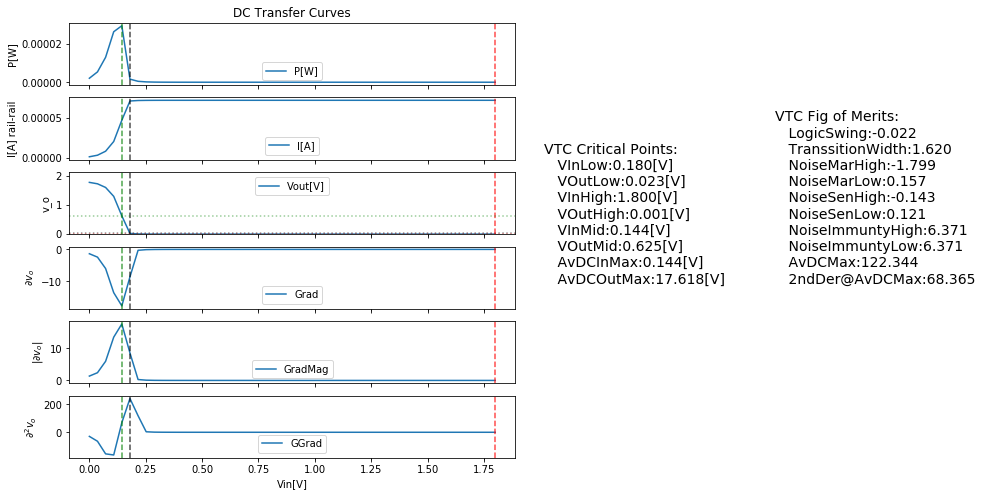

In [5]:
CSR_TB=TwoPortTB(CSR_NMOS, 'CSR_NMOS', Tech)
CSR_TB.SetupCir(**{'RLoad':25e3})
CSR_TB.VIPTransferCurvesGen()

.title CSR_NMOS_TB
.include /home/iridium/string12oil@gmail.com/MyProjects/EEM-Circuits/MOSFET_Tobs/SpiceLib/TSMC180N.lib
.subckt CSR_NMOS0 VSS VDD VGin VDout
RILoad VSS VDout 25000.0Ohm
MN0 VDout VGin VDD 0 TSMC180nmN l=500nm w=500mm
.ends CSR_NMOS0
Vss Vp 0 1.8V
Vdd 0 Vn 0V
XCSR_NMOS Vp Vn Vin Vout CSR_NMOS0
VS1 1 0 DC 0.14400000000000002V AC SIN(0V 0.16200000000000014V 50Hz 0s 0Hz)
RSR1 1 Vin 50Ohm
RSR2 Vout 2 50Ohm
VS2 2 0 DC 0.6248037038690847V AC SIN(0V 0.002244738607486404V 50Hz 0s 0Hz)


        SX1 Source is Biased at 1.440e-01[V]
        with Amplitude at 1.620e-01[V] ;
        SX2 Source is Biased at 6.248E-01[V]
        with Amplitude at 2.245E-03[V]
        


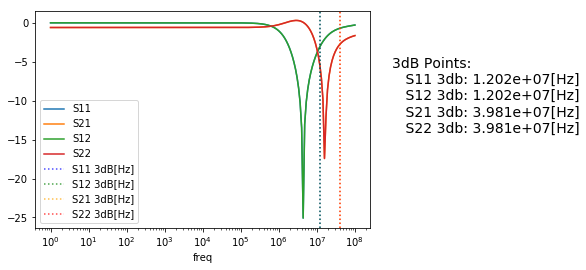

In [6]:
CSR_TB.NASetup()
CSR_TB.NARun(StopHz=100e6)

.title CSR_NMOS_TB
.include /home/iridium/string12oil@gmail.com/MyProjects/EEM-Circuits/MOSFET_Tobs/SpiceLib/TSMC180N.lib
.subckt CSR_NMOS0 VSS VDD VGin VDout
RILoad VSS VDout 25000.0Ohm
MN0 VDout VGin VDD 0 TSMC180nmN l=500nm w=500mm
.ends CSR_NMOS0
Vss Vp 0 1.8V
Vdd 0 Vn 0V
XCSR_NMOS Vp Vn Vin Vout CSR_NMOS0
VHS 1 0 DC 0.14400000000000002V AC SIN(0V 0.16200000000000014V 19905358.0Hz 0s 0Hz)
RHSR 1 Vin 50Ohm
RHLR Vout 0 50Ohm



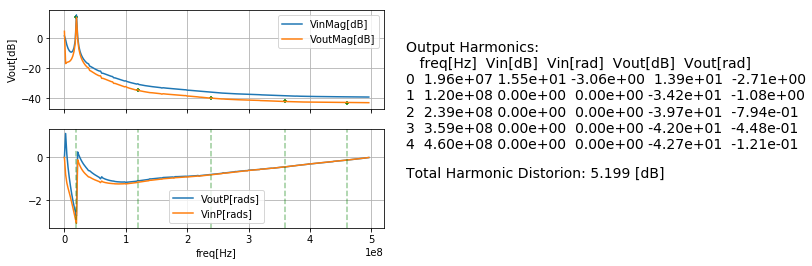

In [7]:
CSR_TB.HarmonicAnylsis()

# Common Drain
The common Drain configuration is also called the Source Follower since, unlike the Common Drain the current source (the load inline with the Id) will convert the channel Id from the Mosfet to voltage in phase with the rising input voltage to the gate. Thus the Common Drain can be though as a form of a buffer in the digital aspect since. 

In the analog domain, the Common Drain is used mostly as a current amplifier since the rising the gate voltage would only further push the MOSFET into saturation that its sourcing current to the inline load increases. Thus the common drain finds wide usage in driving low impedance (high current) demanding loads such as speakers coils and motor coils

## Resistor Biased NMOS Variant 

<img src="CDR_NMOS.png">

In [8]:
class CDR_NMOS(SubCircuitFactory):
    """
    NMOS Resistor Common Drain
    Termanlas:
        VSS: Upper Rail (Resistor Top)
        VDD: Lower Rail (N Source)
        VGin: Voltage to the Gate(In)
        VSout: Voltage from the Ressitor Drain Node (Out)
    Parms:
        NMOS_Tech[str; None]: string with the imported NMOS technology being used 
        RLoad[Ohms; 20e3]: Load Resistaince 
        W [nano meters; 500]: Wdith of the NMOS
        L [nano meters; 500]: Length of the NMOS
        ID [int; 0]: Identify for this supcircuit instaince 
    """
    __nodes__=('VSS', 'VDD', 'VGin', 'VSout')
    
    def __init__(self, NMOS_Tech, RLoad=20e3, W=500, L=500, ID=0):
        self.__name__=f'CDR_NMOS{ID}'
        super().__init__()
        self.ID=ID; self.RLoad=RLoad; self.W=W; self.L=L
        
        #common drain driver
        #Name, Drain, Gate, Source, Body, Model, Width, Length
        self.MOSFET('N0', 'VSS', 'VGin', 'VSout', self.gnd,
                   model=NMOS_Tech, width=W@u_nm, length=L@u_nm)
        
        #Output Load
        self.R(f'ILoad', 'VSout', 'VDD' , RLoad@u_Ω)
        
       
    
    @staticmethod
    def Theory(ID=0):
        pass
        

.title CDR_NMOS_TB
.include /home/iridium/string12oil@gmail.com/MyProjects/EEM-Circuits/MOSFET_Tobs/SpiceLib/TSMC180N.lib
.subckt CDR_NMOS0 VSS VDD VGin VSout
MN0 VSS VGin VSout 0 TSMC180nmN l=500nm w=500nm
RILoad VSout VDD 20000.0Ohm
.ends CDR_NMOS0
Vss Vp 0 1.8V
Vdd 0 Vn 0V
XCDR_NMOS Vp Vn Vin Vout CDR_NMOS0
VVIP_TS Vin 0 0



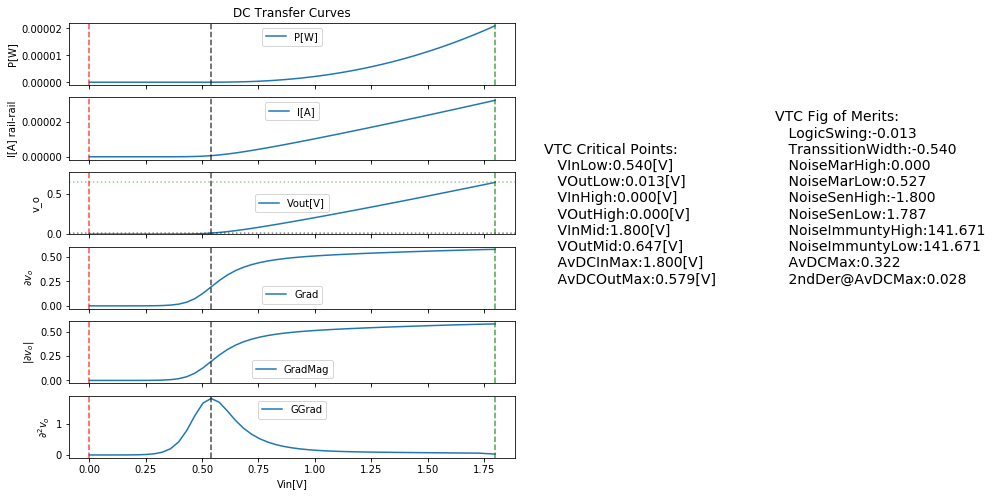

In [9]:
CDR_TB=TwoPortTB(CDR_NMOS, 'CDR_NMOS', Tech)
CDR_TB.SetupCir()
CDR_TB.VIPTransferCurvesGen()

.title CDR_NMOS_TB
.include /home/iridium/string12oil@gmail.com/MyProjects/EEM-Circuits/MOSFET_Tobs/SpiceLib/TSMC180N.lib
.subckt CDR_NMOS0 VSS VDD VGin VSout
MN0 VSS VGin VSout 0 TSMC180nmN l=500nm w=500nm
RILoad VSout VDD 20000.0Ohm
.ends CDR_NMOS0
Vss Vp 0 1.8V
Vdd 0 Vn 0V
XCDR_NMOS Vp Vn Vin Vout CDR_NMOS0
VS1 1 0 DC 1.8000000000000014V AC SIN(0V 0.05400000000000003V 50Hz 0s 0Hz)
RSR1 1 Vin 50Ohm
RSR2 Vout 2 50Ohm
VS2 2 0 DC 0.6473326663392057V AC SIN(0V 0.0012705531349722246V 50Hz 0s 0Hz)


        SX1 Source is Biased at 1.800e+00[V]
        with Amplitude at 5.400e-02[V] ;
        SX2 Source is Biased at 6.473E-01[V]
        with Amplitude at 1.271E-03[V]
        


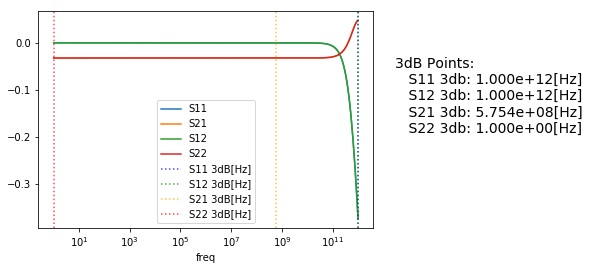

In [10]:
CDR_TB.NASetup()
CDR_TB.NARun(StopHz=100e10)

.title CDR_NMOS_TB
.include /home/iridium/string12oil@gmail.com/MyProjects/EEM-Circuits/MOSFET_Tobs/SpiceLib/TSMC180N.lib
.subckt CDR_NMOS0 VSS VDD VGin VSout
MN0 VSS VGin VSout 0 TSMC180nmN l=500nm w=500nm
RILoad VSout VDD 20000.0Ohm
.ends CDR_NMOS0
Vss Vp 0 1.8V
Vdd 0 Vn 0V
XCDR_NMOS Vp Vn Vin Vout CDR_NMOS0
VHS 1 0 DC 1.8000000000000014V AC SIN(0V 0.05400000000000003V 287719968.0Hz 0s 0Hz)
RHSR 1 Vin 50Ohm
RHLR Vout 0 50Ohm



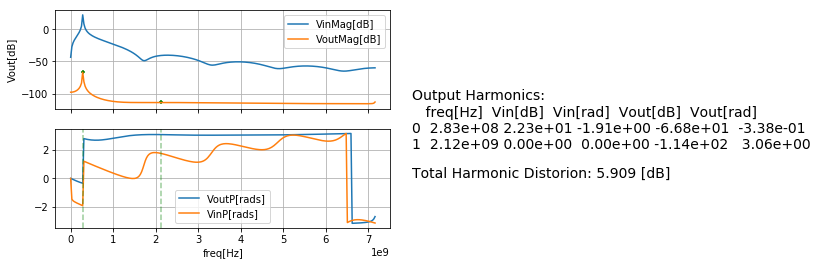

In [11]:
CDR_TB.HarmonicAnylsis()

# Common Gate

<img src="CGR_NMOS.png">

The chaiss ground on the gate is used since very often the common gate to shorted to ground; other times it is floating on a source

In [12]:
class CGR_NMOS(SubCircuitFactory):
    """
    NMOS Resistor Common Gate
    Termanlas:
        VSS: Upper Rail (Resistor Top)
        VGBias: Bias hook up to the gate
        VSin: Voltage to the Source(In)
        VDout: Voltage from the Ressitor Drain Node (Out)
    Parms:
        NMOS_Tech[str; None]: string with the imported NMOS technology being used 
        RLoad[Ohms; 20e3]: Load Resistaince 
        W [meters; 500]: Wdith of the NMOS
        L [meters; 500]: Length of the NMOS
        ID [int; 0]: Identify for this supcircuit instaince 
    """
    __nodes__=('VSS', 'VGBias', 'VSin', 'VDout')
    
    def __init__(self, NMOS_Tech, RLoad=20e3, W=500, L=500, ID=0):
        self.__name__=f'CGR_NMOS{ID}'
        super().__init__()
        
        self.ID=ID; self.RLoad=RLoad; self.W=W; self.L=L
        
        self.R(f'ILoad', 'VSS', 'VDout' , RLoad@u_Ω)
        
        #Name, Drain, Gate, Source, Body, Model, Width, Length
        self.MOSFET('N0', 'VDout', 'VGBias', 'VSin', self.gnd,
                   model=NMOS_Tech, width=W@u_nm, length=L@u_nm)
        
    @staticmethod
    def Theory(ID=0):
        pass
        

Need to write seprate test bench for CG

# Diode Configuration

<img src="DiodeR_NMOS.png">

In [13]:
class DiodeR_NMOS(SubCircuitFactory):
    """
    NMOS Resistor Inverter/Common Source/Class-A Amp
    Termanlas:
        VSS: Upper Rail (Resistor Top)
        VDD: Lower Rail (N Source)
        VDout: Voltage from the Ressitor Drain Node (Out)
    Parms:
        NMOS_Tech[str; None]: string with the imported NMOS technology being used 
        RLoad[Ohms; 20e3]: Load Resistaince 
        W [nano meters; 500]: Wdith of the NMOS
        L [nano meters; 500]: Length of the NMOS
        NameNum [int; 0]: Identify for this supcircuit instaince 
    """
    __nodes__=('VSS', 'VDD', 'VDout')
    
    def __init__(self, NMOS_Tech, RLoad=20e3, 
                 W=500, L=500, ID=0):
        self.__name__=f'DiodeR_NMOS{ID}'
        super().__init__()
        
        self.ID=ID; self.RLoad=RLoad; self.W=W; self.L=L
        
        self.R(f'ILoad', 'VSS', 'VDout' , RLoad@u_Ω)
        
        #Name, Drain, Gate, Source, Body, Model, Width, Length
        self.MOSFET('N0', 'VDout', 'VDout', 'VDD', self.gnd,
                   model=NMOS_Tech, width=W@u_nm, length=L@u_nm)
        
    
    @staticmethod
    def Theory(ID=0):
        pass
        

Need to write seprate testbench

# Cascode 

<img src="CascodeR_NMOS.png">

In [14]:
class CascodeR_NMOS(SubCircuitFactory):
    """
     NMOS Resistor Loaded Cascode
    Termanlas:
        VSS: Upper Rail (Resistor Top)
        VGBias: Bias hook up to the gate
        VDD: Lower Rail (N Source)
        VgDout: Voltage from the Ressitor Common Gate Drain Node (Out)
        VsGin: Voltage to the Common Source Gate (In)
    Parms:
        NMOS_Tech[str; None]: string with the imported NMOS technology being used 
        RLoad[Ohms; 20e3]: Load Resistaince 
        Wg [nano meters; 500]: Wdith of the Common Gate NMOS
        Lg [nano meters; 500]: Length of the  Common Gate NMOS
        Ws [nano meters; 500]: Wdith of the Common Soure NMOS
        Ls [nano meters; 500]: Length of the Common Source NMOS
        ID [int; 0]: Identify for this supcircuit instaince 
    """
    __nodes__=('VSS', 'VGBias', 'VDD', 'VgDout', 'VsGin')
    
    def __init__(self, NMOS_Tech, RLoad=20e3, 
                 Wg=500, Lg=500, 
                 Ws=500, Ls=500, 
                 ID=0):
        self.__name__=f'CascodeR_NMOS{ID}'
        super().__init__()
        
        self.ID=ID; self.RLoad=RLoad; 
        self.Ws=Ws; self.Ls=Ls; self.Ws=Ws; self.Ls=Ls
        
        self.R(f'ILoad', 'VSS', 'VgDout' , RLoad@u_Ω)
        
        
        #Common Gate
        #Name, Drain, Gate, Source, Body, Model, Width, Length
        self.MOSFET('NG', 'VgDout', 'VGBias', '1', self.gnd,
                   model=NMOS_Tech, width=Wg@u_nm, length=Lg@u_nm)
        
        #Common Source
        self.MOSFET('NS', '1', 'VsGin', 'VDD', self.gnd,
                   model=NMOS_Tech, width=Ws@u_nm, length=Ls@u_nm)
        
    
    @staticmethod
    def Theory(ID=0):
        pass
        

Need to write seprate test bench

# Foloded Cascode

<img src="FoldedCascodeR_NMOS.png">

In [15]:
class CascodeR_NMOS(SubCircuitFactory):
    """
     NMOS Resistor Loaded Cascode
    Termanlas:
        VSS: Upper Rail (Resistor Top)
        VGBias: Bias hook up to the gate
        VDD: Lower Rail (N Source)
        VgDout: Voltage from the Ressitor Common Gate Drain Node (Out)
        VsGin: Voltage to the Common Source Gate (In)
    Parms:
        NMOS_Tech[str; None]: string with the imported NMOS technology being used 
        RSLoad[Ohms; 20e3]: Load Resistaince for Common Source
        RGLoad[Ohms; 20e3]: Load Resistaince for Common Gate
        Wg [nano meters; 500]: Wdith of the Common Gate NMOS
        Lg [nano meters; 500]: Length of the  Common Gate NMOS
        Ws [nano meters; 500]: Wdith of the Common Soure NMOS
        Ls [nano meters; 500]: Length of the Common Source NMOS
        ID [int; 0]: Identify for this supcircuit instaince 
    """
    __nodes__=('VSS', 'VGBias', 'VDD', 'VgDout', 'VsGin')
    
    def __init__(self, NMOS_Tech, 
                 RSLoad=20e3, RGLoad=20e3,
                 Wg=500, Lg=500, 
                 Ws=500, Ls=500, 
                 ID=0):
        self.__name__=f'CascodeR_NMOS{ID}'
        super().__init__()
        
        self.ID=ID; 
        self.RSLoad=RSLoad; 
        self.Ws=Ws; self.Ls=Ls; self.Ws=Ws; self.Ls=Ls
        
        #left rail to rail
        self.R(f'ISLoad', 'VSS', '1' , RSLoad@u_Ω)
        
        
        #Name, Drain, Gate, Source, Body, Model, Width, Length

        
        #Common Source
        self.MOSFET('NS', '1', 'VsGin', 'VDD', self.gnd,
                   model=NMOS_Tech, width=Ws@u_nm, length=Ls@u_nm)
        
        #Right 1 to Rail
        #Common Gate
        self.MOSFET('NG', 'VgDout', 'VGBias', '1', self.gnd,
                   model=NMOS_Tech, width=Wg@u_nm, length=Lg@u_nm)
        
        self.R(f'IGLoad', 'VgDout', 'VDD' , RGLoad@u_Ω)

        
    
    @staticmethod
    def Theory(ID=0):
        pass
        

 Need to write seprate test bench

# Differintal Pair 

<img src="DiffPairR_NMOS.png">

In [16]:
class DiffPairR_NMOS(SubCircuitFactory):
    """
    NMOS Resistor Inverter/Common Source/Class-A Amp
    Termanlas:
        VSS: Upper Rail (Resistor Top)
        VDD: Lower Rail (N Source)
        VLin: Voltage to the Left Gate(In)
        VRin: Voltage to the Right Gate(In)
        VLout: Voltage from the Ressitor Drain Node (Out) Left
        VRout: Voltage from the Ressitor Drain Node (Out) Right
    Parms:
        NMOS_Tech[str; None]: string with the imported NMOS technology being used 
        RULoad[Ohms; 20e3]: Load Resistaince at Drains
        RBLoad[Ohms; 20e3]: Common Bias Load Resistaince 
        WL [nano meters; 500]: Wdith of the NMOS
        LL [nano meters; 500]: Length of the NMOS
        WR [nano meters; 500]: Wdith of the NMOS
        LR [nano meters; 500]: Length of the NMOS
        ID [int; 0]: Identify for this supcircuit instaince 
    """
    __nodes__=('VSS', 'VDD', 'VLin', 'VRin', 'VLout', 'VRout')
    
    def __init__(self, NMOS_Tech, 
                 RULoad=20e3, RBLoad=20e3,
                 WL=500, LL=500, 
                 WR=500, LR=500,
                 ID=0):
        self.__name__=f'CSR_NMOS{ID}'
        super().__init__()
        
        self.ID=ID; self.RULoad=RULoad; self.RBLoad=RBLoad; 
        self.WL=WL; self.LL=LL; self.WR=WR; self.LR=LR
        self.include(spice_library[NMOS_Tech])

        #Left Side
        
        self.R('IULoad', 'VSS', 'VLout' , RULoad@u_Ω)
        
        #Name, Drain, Gate, Source, Body, Model, Width, Length
        self.MOSFET('NL', 'VLout', 'VLin', 'C', self.gnd,
                   model=NMOS_Tech, width=WL@u_nm, length=LL@u_nm)
        
        #Right Side
        self.R('IULoad', 'VSS', 'VRout' , RULoad@u_Ω)
        
        #Name, Drain, Gate, Source, Body, Model, Width, Length
        self.MOSFET('NR', 'VRout', 'VRin', 'C', self.gnd,
                   model=NMOS_Tech, width=WR@u_nm, length=LR@u_nm)
        
        
        #Common
        self.R('IBLoad', 'C', 'VDD' , RBLoad@u_Ω)
    
    @staticmethod
    def Theory(ID=0):
        pass
        

need to write seprate test bench

# Current Mirror

<img src="CurMIrrorR_NMOS.png">

In [17]:
class CurMirrorR_NMOS(SubCircuitFactory):
    """
    NMOS Current Mirror Restor Ref Bias
    Termanlas:
        VSS: Upper Rail (Resistor Top)
        VDD: Lower Rail (N Source)
        IRef: Voltage from Slave NMOS Drain 
            to set Ref Current from Master
    Parms:
        NMOS_Tech[str; None]: string with the imported NMOS technology being used 
        RLoad[Ohms; 20e3]: Load Resistaince 
        WM [nano meters; 500]: Wdith of the NMOS
        LM [nano meters; 500]: Length of the NMOS
        WS [nano meters; 500]: Wdith of the NMOS
        LS [nano meters; 500]: Length of the NMOS
        NameNum [int; 0]: Identify for this supcircuit instaince 
    """
    __nodes__=('VSS', 'VDD', 'IRef')
    
    def __init__(self, NMOS_Tech, RLoad=20e3, 
                 WM=500, LM=500, 
                 WS=500, LS=500, 
                 ID=0):
        self.__name__=f'DiodeR_NMOS{ID}'
        super().__init__()
        
        self.ID=ID; self.RLoad=RLoad
        self.WM=WM; self.LM=LM; self.WS=WS; self.LS=LS
        
        self.R(f'ILoad', 'VSS', 'C' , RLoad@u_Ω)
        
        #Master
        #Name, Drain, Gate, Source, Body, Model, Width, Length
        self.MOSFET('NM', 'C', 'C', 'VDD', self.gnd,
                   model=NMOS_Tech, width=WM@u_nm, length=LM@u_nm)
        #Slave
        self.MOSFET('NS', 'IRef', 'C', 'VDD', self.gnd,
                   model=NMOS_Tech, width=WS@u_nm, length=LS@u_nm)
    
    @staticmethod
    def Theory(ID=0):
        pass
        

Need to write seprate testbench